In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from oodeel.models.load_utils import get_model
from oodeel.methods.mls import MLS
from oodeel.methods.dknn import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets.data_handler import DataHandler


2022-09-21 17:13:47.700766: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-21 17:13:47.861121: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-21 17:13:47.861217: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Two datasets experiment

In [2]:
data_handler = DataHandler()

#### MNIST
# Load the data and split it between train and test sets
(x_train, y_train), (x_id, y_ood) = data_handler.load("mnist")
#### Fashion MNIST

# Load the data and split it between train and test sets
_ , (x_ood, y_ood) = data_handler.load("fashion_mnist")

x, labels = data_handler.merge(x_id, x_ood)


2022-09-21 17:14:11.171638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-21 17:14:11.172084: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-21 17:14:11.172262: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (B20212474): /proc/driver/nvidia/version does not exist
2022-09-21 17:14:11.175637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:

model = get_model("../saved_models/mnist_model")

### MLS

0.9947957849999999


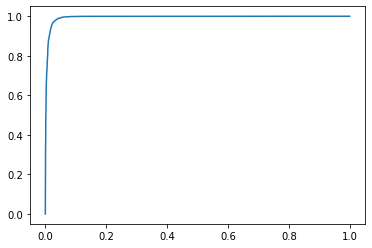

In [3]:

%autoreload 2

oodmodel = MLS(output_activations=["linear"])
oodmodel.fit(model)
scores = oodmodel.score(x)

fpr, tpr = get_curve(scores, labels)
(auroc) = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()

### DKNN

0.791859


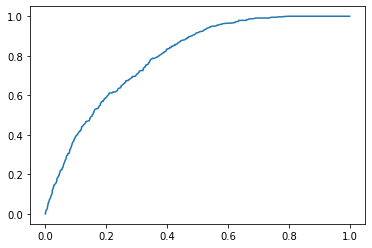

In [4]:
%autoreload 2

## This time need a dataset to fit KNN score
x, labels = data_handler.merge(x_id[:1000], x_ood[:1000])

oodmodel = DKNN()
oodmodel.fit(model, x_train[:10000])
scores = oodmodel.score(x)

fpr, tpr = get_curve(scores, labels)
(auroc) = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()

## Single dataset experiment

(Leave-$k$-classes-out training).
First, we need to define a training function

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

def training_mnist(train_data, config=None):
    x_train, y_train = train_data
    input_shape = (28, 28, 1)
    num_classes=np.unique(y_train).shape[0]

    y_train = keras.utils.to_categorical(y_train, num_classes)

    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )

    batch_size = 128
    epochs = 5

    # compile and fit
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)    

    return model


In [16]:
data_handler = DataHandler()

(x_train, y_train), (x_test, y_test) = data_handler.load("mnist")

inc_labels = [0, 1, 2, 3, 4]

# Here we have to filter x_test to obtain x_id and x_ood
(x_train_id, y_train_id), _ = data_handler.filter(x_train, y_train, inc_labels=inc_labels) 
(x_id, y_id), (x_ood, y_ood) = data_handler.filter(x_test, y_test, inc_labels=inc_labels) 


In [ ]:

model = training_mnist(train_data=(x_train_id, y_train_id))

## MLS

0.93249272767966


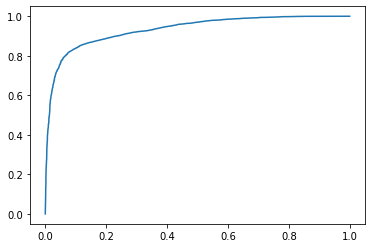

In [17]:
%autoreload 2


x, labels = data_handler.merge(x_id, x_ood)

oodmodel = MLS(output_activations=["linear"])
oodmodel.fit(model)
scores = oodmodel.score(x)

fpr, tpr = get_curve(scores, labels)
(auroc) = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()

### DKNN

0.9329465


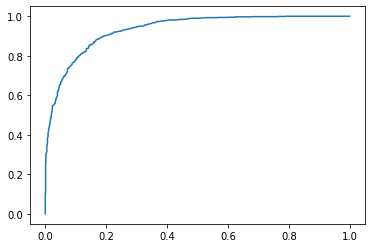

In [18]:
%autoreload 2

x, labels = data_handler.merge(x_id[:1000], x_ood[:1000])

oodmodel = DKNN()
oodmodel.fit(model, x_train_id[:10000])
scores = oodmodel.score(x)

fpr, tpr = get_curve(scores, labels)
(auroc) = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()